# Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import math
import datetime as dt
import json
import requests
from tqdm import tqdm

In [2]:
import geopandas as gpd
import geojson
import h3
import osm2geojson
import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString
from geopy.distance import geodesic, great_circle

In [3]:
import plotly.graph_objects as go
import plotly.express as px

In [4]:
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

In [5]:
pd.options.display.max_rows = 300
pd.options.display.max_columns = 300

In [18]:
import warnings
warnings.simplefilter('ignore')

# Login to DWH

In [6]:
from tochkaml.db.dwh import connect_to_dwh

In [7]:
dwh_login = 'BOCHKAREV_DV'

In [8]:
dwh_pass = 'r5eN3Y6z'

In [9]:
dwh_connection = connect_to_dwh(dwh_login, dwh_pass)

Using 10.103.40.226


In [10]:
from tochkaml import storage

# Region

In [18]:
# reg = '66' # Екатеринбург
# reg = '52' # Нижний Новгород
# reg = '72' # Тюмень
# reg = '45' # Курган
# reg = '50' # Московская
# reg = '23' # Краснодар
# reg = '61' # Ростовская
# reg = '02' # Башкирия
# reg = '16' # Татарстан
# reg = '74' # Челябинск
# reg = '63' # Самара
reg = '70' # Томск

In [20]:
regions = [
    '24', # Красноярск
    '26', # Ставрополь
    '54', # Новосибирск
    '42', # Кемерово
    '59', # Пермь
    '34', # Волгоград
    '64', # Саратов
    '38', # Иркутск
    '22', # Барнаул
    '36', # Воронеж
    '56', # Оренбург
    # '55', # Омск
    # '25', # Владивосток
    # '47', # Санкт-Петербург
    # '86', # Ханты-Мансийск
    # '31', # Белгород
    # '18', # Ижевск
    # '71', # Тула
    # '33', # Владимир
    # '58', # Пенза
    # '27', # Хабаровск
    # '69', # Тверь
    # '43', # Киров
    # '76', # Ярославль
    # '73', # Ульяновск
    # '21', # Чебоксары
    # '32', # Брянск
    # '35', # Вологда
    # '29', # Архангельск
    # '48', # Липецк
    # '62', # Рязань
    # '46', # Курск
    # '75', # Чита
    # '68', # Тамбов
    # '37', # Иваново
    # '30', # Астрахань
    # '40', # Калуга
    # '3', # Улан-Удэ
    # '39', # Калининград
    # '67', # Смоленск
    # '14', # Якутск
    # '11', # Сыктывкар
]

In [21]:
len(regions)

11

# EGRUL

In [13]:
def get_df_inn_region(region):
    df_inn_region = pd.read_sql_query(f"""
        SELECT
              E.inn
            , E.tax_agency_code
            , E.begin_date
            , E.end_date
            , E.end_code
            , E.full_address
            , E.kladr_code
            , E.main_okved

            , ERUZ.inn inn_eruz
            , ERUZ.start_reg_date
            , ERUZ.end_reg_date

            ,D.year
            ,CASE WHEN D.id IS NULL THEN -1 ELSE D.correction_num END correction_num

            ,COALESCE(
                B.assets_balance_fiscal_period,
                BS.assets_balance_fiscal_period,
                0
                )
                *
                CASE
                    WHEN D.okei = 383 THEN 1
                    WHEN D.okei = 384 THEN 1e3
                    WHEN D.okei = 385 THEN 1e6
                    ELSE 1
                END
                assets_balance

            ,COALESCE(
                B.short_borrowed_funds_fiscal_period,
                BS.short_borrowed_funds_fiscal_period,
                0
                )
                *
                CASE
                    WHEN D.okei = 383 THEN 1
                    WHEN D.okei = 384 THEN 1e3
                    WHEN D.okei = 385 THEN 1e6
                    ELSE 1
                END
                short_borrowed_funds

            ,COALESCE(
                B.long_borrowed_funds_fiscal_period,
                BS.long_borrowed_funds_fiscal_period,
                0
                )
                *
                CASE
                    WHEN D.okei = 383 THEN 1
                    WHEN D.okei = 384 THEN 1e3
                    WHEN D.okei = 385 THEN 1e6
                    ELSE 1
                END
                long_borrowed_funds

            ,COALESCE(
                FR.revenue_fiscal_year,
                FRS.revenue_fiscal_year,
                0
                )
                *
                CASE
                    WHEN D.okei = 383 THEN 1
                    WHEN D.okei = 384 THEN 1e3
                    WHEN D.okei = 385 THEN 1e6
                    ELSE 1
                END
                revenue

            ,COALESCE(
                FR.net_profit_loss_fiscal_year,
                FRS.net_profit_loss_fiscal_year,
                0
                )
                *
                CASE
                    WHEN D.okei = 383 THEN 1
                    WHEN D.okei = 384 THEN 1e3
                    WHEN D.okei = 385 THEN 1e6
                    ELSE 1
                END
                net_profit_loss

        FROM
            DATAMART.EGRUL E

            LEFT JOIN (
                SELECT
                      inn
                    , MAX(start_reg_date) start_reg_date
                    , MAX(end_reg_date) end_reg_date
                FROM CORE.ESB_ERUZ_CONTRACTOR
                GROUP BY inn
                ) ERUZ
                ON E.inn = ERUZ.inn

            LEFT JOIN STAGE.GIRBO_TAX_PAYER TP
                ON E.inn = TP.org_inn
            LEFT JOIN STAGE.GIRBO_DOCUMENT D
                ON TP.id = D.id AND D.year = 2020 AND D.period = 34
            LEFT JOIN STAGE.GIRBO_BALANCE B
                ON TP.id = B.id
            LEFT JOIN STAGE.GIRBO_FINANCIAL_RESULT FR
                ON TP.id = FR.id
            LEFT JOIN STAGE.GIRBO_BALANCE_SIMPLE BS
                ON TP.id = BS.id
            LEFT JOIN STAGE.GIRBO_FINANCIAL_RESULT_SIMPLE FRS
                ON TP.id = FRS.id  

        WHERE
            1 = 1
            AND E.kind = 1
            AND SUBSTR(E.inn, 0, 2) = '{region}'
            AND SUBSTR(E.tax_agency_code, 0, 2) = '{region}'
            AND EXTRACT(YEAR FROM E.begin_date) <= 2021
            AND NVL(EXTRACT(YEAR FROM E.end_date),2099) >= 2020
        """,
        dwh_connection)
    
    df_inn_region = df_inn_region.sort_values(
        by='correction_num',
        axis=0,
        ascending=True
    ).drop_duplicates(
        subset='inn',
        keep='last',
        ignore_index=True)
    
    return df_inn_region

# Update FIAS from Karma

In [16]:
api_url = 'https://karma-egrul-http.query.consul-test/api/v1/jsonrpc'

In [17]:
def f_get_data(inn):
    return {
        'jsonrpc':'2.0',
        'method':'get_company',
        'params':{'inn':inn},
        'id':1
    }

In [41]:
def f_parse_egrul(egrul_json):
    
    res = egrul_json['result']['jsondata']
    result = {}
        
    # ЮЛ    
    if 'СвЮЛ' in res:
        result['inn'] = res['СвЮЛ']['ИНН'] if 'ИНН' in res['СвЮЛ'] else None

        # адрес
        if 'СвАдресЮЛ' in res['СвЮЛ']:
            if 'АдресРФ' in res['СвЮЛ']['СвАдресЮЛ']:
                result['kladr_code'] = res['СвЮЛ']['СвАдресЮЛ']['АдресРФ']['КодАдрКладр'] if 'КодАдрКладр' in res['СвЮЛ']['СвАдресЮЛ']['АдресРФ'] else None

            if 'СвАдрЮЛФИАС' in res['СвЮЛ']['СвАдресЮЛ']:
                result['fias_code'] = res['СвЮЛ']['СвАдресЮЛ']['СвАдрЮЛФИАС']['ИдНом'] if 'ИдНом' in res['СвЮЛ']['СвАдресЮЛ']['СвАдрЮЛФИАС'] else None

    return result

# Begin

In [22]:
for reg in regions:
    
    print('--------------------------------')
    print(f"begin {reg}")
    print(dt.datetime.now())
    
    df_inn = get_df_inn_region(reg)
    
    print("finish select")
    print(dt.datetime.now())
    
    df_inn['count_2020'] = 0
    df_inn.loc[
        (df_inn.begin_date.dt.year <= 2020) &
        ((df_inn.end_date.isnull()) | (df_inn.end_date.dt.year >= 2020)),
        'count_2020'
    ] = 1
    

    df_inn['count_2021'] = 0
    df_inn.loc[
        (df_inn.begin_date.dt.year <= 2021) &
        ((df_inn.end_date.isnull()) | (df_inn.end_date.dt.year >= 2021)),
        'count_2021'
    ] = 1

    df_inn['begin_2021'] = 0
    df_inn.loc[
        (df_inn.begin_date.dt.year == 2021),
        'begin_2021'
    ] = 1

    df_inn['end_2021'] = 0
    df_inn.loc[
        (df_inn.end_date.dt.year == 2021),
        'end_2021'
    ] = 1

    print(df_inn.groupby([df_inn.inn.map(len), df_inn.full_address.notnull(), df_inn.kladr_code.notnull()]).size())
    
    print('begin update from karma')
    print(dt.datetime.now())
    
    df_inn_upd = pd.DataFrame(columns=[
        'inn',
        'kladr_code',
        'fias_code'
    ])
    
    for inn in tqdm(df_inn.loc[df_inn.kladr_code.isnull(), 'inn']):
        try:
            response = requests.post(
                api_url,
                json=f_get_data(inn),
                headers={'content-type':'application/json'},
                verify=False
            )
            egrul_json = response.json()
            df_inn_upd = pd.concat(
                [
                    df_inn_upd,
                    pd.DataFrame(f_parse_egrul(egrul_json), index=[0])],
                ignore_index=True
            ) 
        except Exception:
            pass
    
    
    df_inn = df_inn.merge(
        df_inn_upd[['inn', 'fias_code']],
        how = 'left',
        on = 'inn'
    )
    
    print(df_inn.groupby(
        [
            df_inn.inn.map(len),
            df_inn.full_address.notnull(),
            df_inn.kladr_code.notnull(),
            df_inn.fias_code.notnull()
        ]
    ).size())
    
    df_inn['kladr_11'] = df_inn['kladr_code'].str[:11]
    
    print("finish update")
    
    df_inn.to_csv(f'/home/jovyan/work/df_inn_{str(reg)}_2.csv.gz', index=False, sep=';', compression='gzip')
    storage.personal.save(f'df_inn_{str(reg)}_2.csv.gz')
    
    print(f"finish saving {reg}")
    
    df_kladr = pd.DataFrame(df_inn.loc[
        (df_inn.inn.map(len)==10) &
        (df_inn.kladr_code.notnull()) &
        (df_inn.kladr_code.str[:2]==f'{reg}'),
        'kladr_11'
    ].unique())
    
    df_kladr.rename(columns={0:'kladr_11'}, inplace=True)
    
    df_kladr.to_csv(f'/home/jovyan/work/df_kladr_{reg}.csv.gz', index=False, compression='gzip')
    storage.personal.save(f'df_kladr_{reg}.csv.gz')
    
    print(f"finish saving kladr {reg}")
    
    df_fias = pd.DataFrame(df_inn.loc[
        df_inn.fias_code.notnull(),
        'fias_code'
    ].unique())
    
    df_fias.rename(columns={0:'fias_code'}, inplace=True)
    
    df_fias.to_csv(f'/home/jovyan/work/df_fias_{reg}.csv.gz', index=False, compression='gzip')
    storage.personal.save(f'df_fias_{reg}.csv.gz')
    
    print(f"finish saving fias {reg}")
    
    print(f"finish {reg}")
    print('--------------------------------')
    

--------------------------------
begin 24
2022-11-18 15:26:00.974313
finish select
2022-11-18 15:27:52.483648
inn  full_address  kladr_code
10   True          False          16314
                   True          138839
dtype: int64
begin update from karma
2022-11-18 15:27:52.852068


100%|██████████| 31840/31840 [1:09:58<00:00,  7.58it/s]


inn  full_address  kladr_code  fias_code
10   True          False       False         31840
                   True        False        208897
dtype: int64
finish update
2022-11-18 17:28.13 [info     ] check for directory            fs=localfs path=df_inn_54_2.csv.gz
2022-11-18 17:28.13 [info     ] save file                      path=df_inn_54_2.csv.gz
2022-11-18 17:28.13 [info     ] open file for read             fs=localfs path=df_inn_54_2.csv.gz
2022-11-18 17:28.13 [info     ] open file for write            fs=s3fs path=df_inn_54_2.csv.gz
finish saving 54
2022-11-18 17:28.15 [info     ] check for directory            fs=localfs path=df_kladr_54.csv.gz
2022-11-18 17:28.15 [info     ] save file                      path=df_kladr_54.csv.gz
2022-11-18 17:28.15 [info     ] open file for read             fs=localfs path=df_kladr_54.csv.gz
2022-11-18 17:28.15 [info     ] open file for write            fs=s3fs path=df_kladr_54.csv.gz
finish saving kladr 54
2022-11-18 17:28.15 [info     ] ch

100%|██████████| 9521/9521 [16:32<00:00,  9.60it/s]  


inn  full_address  kladr_code  fias_code
10   True          False       False         9521
                   True        False        83495
dtype: int64
finish update
2022-11-18 17:46.43 [info     ] check for directory            fs=localfs path=df_inn_42_2.csv.gz
2022-11-18 17:46.43 [info     ] save file                      path=df_inn_42_2.csv.gz
2022-11-18 17:46.43 [info     ] open file for read             fs=localfs path=df_inn_42_2.csv.gz
2022-11-18 17:46.43 [info     ] open file for write            fs=s3fs path=df_inn_42_2.csv.gz
finish saving 42
2022-11-18 17:46.44 [info     ] check for directory            fs=localfs path=df_kladr_42.csv.gz
2022-11-18 17:46.44 [info     ] save file                      path=df_kladr_42.csv.gz
2022-11-18 17:46.44 [info     ] open file for read             fs=localfs path=df_kladr_42.csv.gz
2022-11-18 17:46.44 [info     ] open file for write            fs=s3fs path=df_kladr_42.csv.gz
finish saving kladr 42
2022-11-18 17:46.44 [info     ] chec

100%|██████████| 15852/15852 [28:17<00:00,  9.34it/s] 


inn  full_address  kladr_code  fias_code
10   True          False       False         15852
                   True        False        126609
dtype: int64
finish update
2022-11-18 18:16.19 [info     ] check for directory            fs=localfs path=df_inn_59_2.csv.gz
2022-11-18 18:16.19 [info     ] save file                      path=df_inn_59_2.csv.gz
2022-11-18 18:16.19 [info     ] open file for read             fs=localfs path=df_inn_59_2.csv.gz
2022-11-18 18:16.19 [info     ] open file for write            fs=s3fs path=df_inn_59_2.csv.gz
finish saving 59
2022-11-18 18:16.19 [info     ] check for directory            fs=localfs path=df_kladr_59.csv.gz
2022-11-18 18:16.19 [info     ] save file                      path=df_kladr_59.csv.gz
2022-11-18 18:16.19 [info     ] open file for read             fs=localfs path=df_kladr_59.csv.gz
2022-11-18 18:16.19 [info     ] open file for write            fs=s3fs path=df_kladr_59.csv.gz
finish saving kladr 59
2022-11-18 18:16.20 [info     ] ch

100%|██████████| 8804/8804 [12:29<00:00, 11.75it/s]


inn  full_address  kladr_code  fias_code
10   True          False       False         8804
                   True        False        76549
dtype: int64
finish update
2022-11-18 18:30.01 [info     ] check for directory            fs=localfs path=df_inn_34_2.csv.gz
2022-11-18 18:30.01 [info     ] save file                      path=df_inn_34_2.csv.gz
2022-11-18 18:30.01 [info     ] open file for read             fs=localfs path=df_inn_34_2.csv.gz
2022-11-18 18:30.01 [info     ] open file for write            fs=s3fs path=df_inn_34_2.csv.gz
finish saving 34
2022-11-18 18:30.02 [info     ] check for directory            fs=localfs path=df_kladr_34.csv.gz
2022-11-18 18:30.02 [info     ] save file                      path=df_kladr_34.csv.gz
2022-11-18 18:30.02 [info     ] open file for read             fs=localfs path=df_kladr_34.csv.gz
2022-11-18 18:30.02 [info     ] open file for write            fs=s3fs path=df_kladr_34.csv.gz
finish saving kladr 34
2022-11-18 18:30.02 [info     ] chec

100%|██████████| 7558/7558 [16:04<00:00,  7.83it/s]


inn  full_address  kladr_code  fias_code
10   True          False       False         7558
                   True        False        89279
dtype: int64
finish update
2022-11-18 18:48.05 [info     ] check for directory            fs=localfs path=df_inn_64_2.csv.gz
2022-11-18 18:48.05 [info     ] save file                      path=df_inn_64_2.csv.gz
2022-11-18 18:48.05 [info     ] open file for read             fs=localfs path=df_inn_64_2.csv.gz
2022-11-18 18:48.05 [info     ] open file for write            fs=s3fs path=df_inn_64_2.csv.gz
finish saving 64
2022-11-18 18:48.05 [info     ] check for directory            fs=localfs path=df_kladr_64.csv.gz
2022-11-18 18:48.05 [info     ] save file                      path=df_kladr_64.csv.gz
2022-11-18 18:48.05 [info     ] open file for read             fs=localfs path=df_kladr_64.csv.gz
2022-11-18 18:48.05 [info     ] open file for write            fs=s3fs path=df_kladr_64.csv.gz
finish saving kladr 64
2022-11-18 18:48.05 [info     ] chec

100%|██████████| 12592/12592 [18:07<00:00, 11.58it/s] 


inn  full_address  kladr_code  fias_code
10   True          False       False         12592
                   True        False        111409
dtype: int64
finish update
2022-11-18 19:07.10 [info     ] check for directory            fs=localfs path=df_inn_38_2.csv.gz
2022-11-18 19:07.10 [info     ] save file                      path=df_inn_38_2.csv.gz
2022-11-18 19:07.10 [info     ] open file for read             fs=localfs path=df_inn_38_2.csv.gz
2022-11-18 19:07.10 [info     ] open file for write            fs=s3fs path=df_inn_38_2.csv.gz
finish saving 38
2022-11-18 19:07.11 [info     ] check for directory            fs=localfs path=df_kladr_38.csv.gz
2022-11-18 19:07.11 [info     ] save file                      path=df_kladr_38.csv.gz
2022-11-18 19:07.11 [info     ] open file for read             fs=localfs path=df_kladr_38.csv.gz
2022-11-18 19:07.11 [info     ] open file for write            fs=s3fs path=df_kladr_38.csv.gz
finish saving kladr 38
2022-11-18 19:07.11 [info     ] ch

100%|██████████| 15747/15747 [19:45<00:00, 13.29it/s]


inn  full_address  kladr_code  fias_code
10   True          False       False        15747
                   True        False        92240
dtype: int64
finish update
2022-11-18 19:27.52 [info     ] check for directory            fs=localfs path=df_inn_22_2.csv.gz
2022-11-18 19:27.52 [info     ] save file                      path=df_inn_22_2.csv.gz
2022-11-18 19:27.52 [info     ] open file for read             fs=localfs path=df_inn_22_2.csv.gz
2022-11-18 19:27.52 [info     ] open file for write            fs=s3fs path=df_inn_22_2.csv.gz
finish saving 22
2022-11-18 19:27.52 [info     ] check for directory            fs=localfs path=df_kladr_22.csv.gz
2022-11-18 19:27.52 [info     ] save file                      path=df_kladr_22.csv.gz
2022-11-18 19:27.52 [info     ] open file for read             fs=localfs path=df_kladr_22.csv.gz
2022-11-18 19:27.52 [info     ] open file for write            fs=s3fs path=df_kladr_22.csv.gz
finish saving kladr 22
2022-11-18 19:27.52 [info     ] chec

100%|██████████| 18335/18335 [22:53<00:00, 13.35it/s]


inn  full_address  kladr_code  fias_code
10   True          False       False        18335
                   True        False        94996
dtype: int64
finish update
2022-11-18 19:52.37 [info     ] check for directory            fs=localfs path=df_inn_36_2.csv.gz
2022-11-18 19:52.37 [info     ] save file                      path=df_inn_36_2.csv.gz
2022-11-18 19:52.37 [info     ] open file for read             fs=localfs path=df_inn_36_2.csv.gz
2022-11-18 19:52.37 [info     ] open file for write            fs=s3fs path=df_inn_36_2.csv.gz
finish saving 36
2022-11-18 19:52.38 [info     ] check for directory            fs=localfs path=df_kladr_36.csv.gz
2022-11-18 19:52.38 [info     ] save file                      path=df_kladr_36.csv.gz
2022-11-18 19:52.38 [info     ] open file for read             fs=localfs path=df_kladr_36.csv.gz
2022-11-18 19:52.38 [info     ] open file for write            fs=s3fs path=df_kladr_36.csv.gz
finish saving kladr 36
2022-11-18 19:52.38 [info     ] chec

100%|██████████| 6018/6018 [08:06<00:00, 12.37it/s]


inn  full_address  kladr_code  fias_code
10   True          False       False         6018
                   True        False        63394
dtype: int64
finish update
2022-11-18 20:02.06 [info     ] check for directory            fs=localfs path=df_inn_56_2.csv.gz
2022-11-18 20:02.06 [info     ] save file                      path=df_inn_56_2.csv.gz
2022-11-18 20:02.06 [info     ] open file for read             fs=localfs path=df_inn_56_2.csv.gz
2022-11-18 20:02.06 [info     ] open file for write            fs=s3fs path=df_inn_56_2.csv.gz
finish saving 56
2022-11-18 20:02.06 [info     ] check for directory            fs=localfs path=df_kladr_56.csv.gz
2022-11-18 20:02.06 [info     ] save file                      path=df_kladr_56.csv.gz
2022-11-18 20:02.06 [info     ] open file for read             fs=localfs path=df_kladr_56.csv.gz
2022-11-18 20:02.06 [info     ] open file for write            fs=s3fs path=df_kladr_56.csv.gz
finish saving kladr 56
2022-11-18 20:02.06 [info     ] chec

## KLADR Dadata

In [71]:
from dadata import Dadata

In [72]:
login = 'ow-admin@home/jovyan/work/tochka.com'
password = 'Tochka-geo61'
token = 'ed714e4b6c4306abf7b9813c3447963b693e1370'

In [73]:
dadata = Dadata(token)

In [7]:
df_kladr = pd.read_csv(f'/home/jovyan/work/df_kladr_{reg}.csv.gz', compression='gzip', dtype={'kladr_11':str})

In [75]:
df_kladr.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 317 entries, 0 to 316

Data columns (total 1 columns):

 #   Column    Non-Null Count  Dtype 

---  ------    --------------  ----- 

 0   kladr_11  317 non-null    object

dtypes: object(1)

memory usage: 2.6+ KB


In [76]:
df_kladr.head()

,kladr_11
0,70000001000
1,70013000020
2,70000004000
3,70009001000
4,70017000012


In [79]:
df_kladr.groupby(df_kladr.kladr_11.map(len)).size()

kladr_11
11    317
dtype: int64

In [82]:
df_kladr['kladr'] = df_kladr['kladr_11'] + '00'

In [83]:
df_kladr.head()

,kladr_11,kladr
0,70000001000,7000000100000
1,70013000020,7001300002000
2,70000004000,7000000400000
3,70009001000,7000900100000
4,70017000012,7001700001200


In [84]:
kladr_list = df_kladr['kladr']

In [85]:
kladr_list

0      7000000100000
1      7001300002000
2      7000000400000
3      7000900100000
4      7001700001200
           ...      
312    7000900001500
313    7000300000700
314    7000000102000
315    7001700008400
316    7001700001300
Name: kladr, Length: 317, dtype: object

In [74]:
def kladr_to_coodr(kladr):
    response = dadata.find_by_id("address", kladr)
    address = response[0]['unrestricted_value']
    latitude = response[0]['data']['geo_lat']
    longitude = response[0]['data']['geo_lon']
    return address, latitude, longitude

In [86]:
addresses = []
latitudes = []
longitudes = []

for kladr in tqdm(kladr_list):
    try:
        address, latitude, longitude = kladr_to_coodr(kladr)
        addresses.append(address)
        latitudes.append(latitude)
        longitudes.append(longitude)
        # print(address, latitude, longitude)
    except Exception as e:
        addresses.append(None)
        latitudes.append(None)
        longitudes.append(None)
        # print(e)

100%|██████████| 317/317 [00:02<00:00, 113.81it/s]


In [87]:
len(addresses)

317

In [88]:
df_kladr['address'] = addresses

In [89]:
df_kladr['latitude'] = latitudes

In [90]:
df_kladr['longitude'] = longitudes

In [91]:
df_kladr.shape

(317, 5)

In [92]:
df_kladr.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 317 entries, 0 to 316

Data columns (total 5 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   kladr_11   317 non-null    object

 1   kladr      317 non-null    object

 2   address    0 non-null      object

 3   latitude   0 non-null      object

 4   longitude  0 non-null      object

dtypes: object(5)

memory usage: 12.5+ KB


In [93]:
df_kladr.head()

,kladr_11,kladr,address,latitude,longitude
0,70000001000,7000000100000,None,None,None
1,70013000020,7001300002000,None,None,None
2,70000004000,7000000400000,None,None,None
3,70009001000,7000900100000,None,None,None
4,70017000012,7001700001200,None,None,None


In [23]:
df_kladr.to_csv(f'/home/jovyan/work/df_kladr_{reg}_upd.csv.gz', sep=';', index=False, compression='gzip')

In [ ]:
storage.personal.save(f'df_kladr_{reg}_upd.csv.gz')

In [123]:
df_kladr_upd = pd.read_csv(
    f'/home/jovyan/work/df_kladr_{reg}_upd.csv.gz',
    sep=';',
    compression='gzip',
    dtype={'kladr_11':str, 'kladr':str}
)

In [124]:
df_kladr_upd.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 317 entries, 0 to 316

Data columns (total 5 columns):

 #   Column     Non-Null Count  Dtype  

---  ------     --------------  -----  

 0   kladr_11   317 non-null    object 

 1   kladr      317 non-null    object 

 2   address    312 non-null    object 

 3   latitude   310 non-null    float64

 4   longitude  310 non-null    float64

dtypes: float64(2), object(3)

memory usage: 12.5+ KB


In [125]:
df_kladr_upd.head()

,kladr_11,kladr,address,latitude,longitude
0,70000001000,7000000100000,"634000, Томская обл, г Томск",56.484680,84.948197
1,70013000020,7001300002000,"636953, Томская обл, Первомайский р-н, село Ку...",56.949172,86.465613
2,70000004000,7000000400000,"636780, Томская обл, г Стрежевой",60.732801,77.604047
3,70009001000,7000900100000,"636460, Томская обл, Колпашевский р-н, г Колпа...",58.311384,82.902679
4,70017000012,7001700001200,"634582, Томская обл, Томский р-н, село Алексан...",56.741430,85.388326


## FIAS Dadata

In [101]:
from dadata import Dadata

In [102]:
login = 'ow-admin@home/jovyan/work/tochka.com'
password = 'Tochka-geo61'
token = 'ed714e4b6c4306abf7b9813c3447963b693e1370'

In [103]:
dadata = Dadata(token)

In [6]:
df_fias = pd.read_csv(f'/home/jovyan/work/df_fias_{reg}.csv.gz', compression='gzip')

In [104]:
df_fias.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2149 entries, 0 to 2148

Data columns (total 1 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   fias_code  2149 non-null   object

dtypes: object(1)

memory usage: 16.9+ KB


In [105]:
df_fias.head()

,fias_code
0,83da1256-a96d-47c7-9dce-78742c0fa454
1,0a4d3c20-a7e0-4cd9-b17e-9022dc79a663
2,e940a45e-b29f-451e-a0f3-1974df8e22ae
3,16ba864e-241a-44a5-ac76-d30d591a9280
4,683d98a6-5eee-46d8-aba6-030af4d2b060


In [106]:
fias_list = df_fias['fias_code']

In [107]:
fias_list

0       83da1256-a96d-47c7-9dce-78742c0fa454
1       0a4d3c20-a7e0-4cd9-b17e-9022dc79a663
2       e940a45e-b29f-451e-a0f3-1974df8e22ae
3       16ba864e-241a-44a5-ac76-d30d591a9280
4       683d98a6-5eee-46d8-aba6-030af4d2b060
                        ...                 
2144    05ce32f5-e167-44d9-b973-2dc681222e59
2145    1b14b308-b84b-42cf-8bc6-fe4717b3dca6
2146    8283393c-1b6e-40f7-8ae2-a4ca386b95bc
2147    768dd377-e84c-4a09-9f33-3fe896fd56b5
2148    21f87f43-c2d8-4f0f-b5f0-87a6c7dd15da
Name: fias_code, Length: 2149, dtype: object

In [108]:
def fias_to_coodr(fias):
    response = dadata.find_by_id("address", str(fias))
    address = response[0]['unrestricted_value']
    latitude = response[0]['data']['geo_lat']
    longitude = response[0]['data']['geo_lon']
    return address, latitude, longitude

In [109]:
addresses_fias = []
latitudes_fias = []
longitudes_fias = []

for kladr in tqdm(fias_list[:15]):
    try:
        address, latitude, longitude = fias_to_coodr(kladr)
        addresses_fias.append(address)
        latitudes_fias.append(latitude)
        longitudes_fias.append(longitude)
        # print(address, latitude, longitude)
    except Exception as e:
        addresses_fias.append(None)
        latitudes_fias.append(None)
        longitudes_fias.append(None)
        # print(e)

100%|██████████| 15/15 [00:00<00:00, 145.54it/s]


In [110]:
len(addresses_fias)

15

In [111]:
addresses_fias

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [112]:
latitudes_fias

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [113]:
longitudes_fias

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [114]:
addresses_fias = []
latitudes_fias = []
longitudes_fias = []

for kladr in tqdm(fias_list):
    try:
        address, latitude, longitude = fias_to_coodr(kladr)
        addresses_fias.append(address)
        latitudes_fias.append(latitude)
        longitudes_fias.append(longitude)
        # print(address, latitude, longitude)
    except Exception as e:
        addresses_fias.append(None)
        latitudes_fias.append(None)
        longitudes_fias.append(None)
        # print(e)

100%|██████████| 2149/2149 [00:33<00:00, 63.33it/s] 


In [115]:
len(addresses_fias)

2149

In [116]:
df_fias['address'] = addresses_fias

In [117]:
df_fias['latitude'] = latitudes_fias

In [118]:
df_fias['longitude'] = longitudes_fias

In [119]:
df_fias.shape

(2149, 4)

In [120]:
df_fias.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2149 entries, 0 to 2148

Data columns (total 4 columns):

 #   Column     Non-Null Count  Dtype 

---  ------     --------------  ----- 

 0   fias_code  2149 non-null   object

 1   address    0 non-null      object

 2   latitude   0 non-null      object

 3   longitude  0 non-null      object

dtypes: object(4)

memory usage: 67.3+ KB


In [121]:
df_fias.head()

,fias_code,address,latitude,longitude
0,83da1256-a96d-47c7-9dce-78742c0fa454,None,None,None
1,0a4d3c20-a7e0-4cd9-b17e-9022dc79a663,None,None,None
2,e940a45e-b29f-451e-a0f3-1974df8e22ae,None,None,None
3,16ba864e-241a-44a5-ac76-d30d591a9280,None,None,None
4,683d98a6-5eee-46d8-aba6-030af4d2b060,None,None,None


In [25]:
df_fias.to_csv(f'/home/jovyan/work/df_fias_{reg}_upd.csv.gz', sep=';', index=False, compression='gzip')

In [ ]:
storage.personal.save(f'df_fias_{reg}_upd.csv.gz')

In [126]:
df_fias_upd = pd.read_csv(
    f'/home/jovyan/work/df_fias_{reg}_upd.csv.gz',
    sep=';',
    compression='gzip'
)

In [127]:
df_fias_upd.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2149 entries, 0 to 2148

Data columns (total 4 columns):

 #   Column     Non-Null Count  Dtype  

---  ------     --------------  -----  

 0   fias_code  2149 non-null   object 

 1   address    2149 non-null   object 

 2   latitude   2145 non-null   float64

 3   longitude  2145 non-null   float64

dtypes: float64(2), object(2)

memory usage: 67.3+ KB


In [128]:
df_fias_upd.head()

,fias_code,address,latitude,longitude
0,83da1256-a96d-47c7-9dce-78742c0fa454,"634049, Томская обл, г Томск, Иркутский тракт,...",56.500670,85.005710
1,0a4d3c20-a7e0-4cd9-b17e-9022dc79a663,"634020, Томская обл, г Томск, ул Сибирская, д 80",56.482672,84.993858
2,e940a45e-b29f-451e-a0f3-1974df8e22ae,"634507, Томская обл, Томский р-н, поселок Зона...",56.430987,85.008581
3,16ba864e-241a-44a5-ac76-d30d591a9280,"636844, Томская обл, Асиновский р-н, г Асино, ...",56.999274,86.141671
4,683d98a6-5eee-46d8-aba6-030af4d2b060,"634009, Томская обл, г Томск, ул Бердская",56.511168,84.942942


# Geocoding Data

In [129]:
df_inn.shape

(28648, 24)

In [130]:
df_kladr_upd.shape

(317, 5)

In [131]:
df_inn = df_inn.merge(
    df_kladr_upd[['kladr_11', 'latitude', 'longitude']],
    how='left',
    on='kladr_11'
)

In [132]:
df_inn.shape

(28648, 26)

In [133]:
df_inn.latitude.isnull().sum()

3536

In [134]:
df_fias_upd.shape

(2149, 4)

In [135]:
df_inn = df_inn.merge(
    df_fias_upd[['fias_code', 'latitude', 'longitude']].rename(columns={'latitude':'latitude_fias', 'longitude':'longitude_fias'}),
    how='left',
    on='fias_code'
)

In [136]:
df_inn.shape

(28648, 28)

In [137]:
df_inn.latitude_fias.notnull().sum()

3481

In [138]:
df_inn.loc[df_inn.latitude.isnull(), 'latitude'] = df_inn['latitude_fias']
df_inn.loc[df_inn.longitude.isnull(), 'longitude'] = df_inn['longitude_fias']

In [139]:
df_inn.drop(columns=['latitude_fias', 'longitude_fias'], inplace=True)

In [140]:
df_inn.latitude.isnull().sum()

55

In [141]:
df_inn.longitude.isnull().sum()

55

In [142]:
df_inn.head()

,inn,tax_agency_code,begin_date,end_date,end_code,full_address,kladr_code,main_okved,inn_eruz,start_reg_date,end_reg_date,year,correction_num,assets_balance,short_borrowed_funds,long_borrowed_funds,revenue,net_profit_loss,count_2020,count_2021,begin_2021,end_2021,fias_code,kladr_11,latitude,longitude
0,7017253732,7017,2010-01-20,2021-04-19,415,"634028, ОБЛАСТЬ ТОМСКАЯ, Г. ТОМСК, УЛ. УЧЕБНАЯ...",700000010000827,77.29.2,None,None,None,NaN,-1,0,0,0,0,0,1,1,0,1,NaN,70000001000,56.484680,84.948197
1,7012011923,7025,2018-02-20,2021-12-06,407,"636953, ОБЛАСТЬ ТОМСКАЯ, Р-Н ПЕРВОМАЙСКИЙ, С. ...",700130000200001,49.41.2,None,None,None,NaN,-1,0,0,0,0,0,1,1,0,1,NaN,70013000020,56.949172,86.465613
2,7017367715,7017,2014-12-24,2021-04-12,415,"634050, ОБЛАСТЬ ТОМСКАЯ, Г. ТОМСК, УЛ. ИСТОЧНА...",700000010000295,43.21,None,None,None,NaN,-1,0,0,0,0,0,1,1,0,1,NaN,70000001000,56.484680,84.948197
3,7017416345,7000,2016-12-26,NaT,None,"634030, ОБЛАСТЬ ТОМСКАЯ, Г. ТОМСК, УЛ. ВАСИЛИЯ...",700000010001070,46.32.1,None,None,None,NaN,-1,10101,5149,1500,0,0,1,1,0,0,NaN,70000001000,56.484680,84.948197
4,7017379220,7017,2015-06-15,2021-11-09,415,"634021, ОБЛАСТЬ ТОМСКАЯ, Г. ТОМСК, УЛ. КУЛАГИН...",700000010000394,46.73.6,None,None,None,NaN,-1,0,0,0,0,0,1,1,0,1,NaN,70000001000,56.484680,84.948197


In [143]:
df_inn.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 28648 entries, 0 to 28647

Data columns (total 26 columns):

 #   Column                Non-Null Count  Dtype         

---  ------                --------------  -----         

 0   inn                   28648 non-null  object        

 1   tax_agency_code       28648 non-null  object        

 2   begin_date            28648 non-null  datetime64[ns]

 3   end_date              6595 non-null   datetime64[ns]

 4   end_code              6595 non-null   object        

 5   full_address          28648 non-null  object        

 6   kladr_code            25161 non-null  object        

 7   main_okved            28561 non-null  object        

 8   inn_eruz              3493 non-null   object        

 9   start_reg_date        3475 non-null   object        

 10  end_reg_date          2410 non-null   object        

 11  year                  18740 non-null  float64       

 12  correction_num        28648 non-null  int64         

 13

# Hexes

In [144]:
h3_resolution = 5

In [147]:
hexes_file = f'home/jovyan/work/{reg}.parquet.gzip'

In [148]:
hexes_gdf = gpd.read_parquet(hexes_file)

In [149]:
hexes_gdf.head()

,hex_id,geometry
0,850b128bfffffff,"POLYGON ((78.11260 58.82547, 78.22430 58.89766..."
1,850b8333fffffff,"POLYGON ((87.88468 57.67118, 87.83945 57.76124..."
2,850ba013fffffff,"POLYGON ((79.61531 57.06915, 79.78766 57.05310..."
3,850ba163fffffff,"POLYGON ((80.99313 58.32557, 81.05507 58.23779..."
4,850bac73fffffff,"POLYGON ((81.37080 59.42336, 81.18940 59.44168..."


In [150]:
hexes_gdf.shape

(1123, 2)

In [151]:
hexes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>

RangeIndex: 1123 entries, 0 to 1122

Data columns (total 2 columns):

 #   Column    Non-Null Count  Dtype   

---  ------    --------------  -----   

 0   hex_id    1123 non-null   object  

 1   geometry  1123 non-null   geometry

dtypes: geometry(1), object(1)

memory usage: 17.7+ KB


In [152]:
hexes_gdf['hex_id'].nunique()

1123

In [153]:
map_h3_hexes = folium.Map(location=[58.5, 63], zoom_start=5, width=900, height=700, control_scale=True)

for h in hexes_gdf['geometry']:
    folium.GeoJson(
        h.__geo_interface__,
        style_function=lambda feature: {
            "fillColor": "red",
            "color": "blue",
            "weight": 1,
            "fillOpacity": 0.5,
        },
    ).add_to(map_h3_hexes)

map_h3_hexes

In [154]:
df_inn[f'h3_id_{h3_resolution}'] = None

for index, row in df_inn.iterrows():
    h3_id = h3.geo_to_h3(
        lat = row['latitude'], 
        lng = row['longitude'], 
        resolution = h3_resolution
    )
    df_inn.loc[index, f'h3_id_{h3_resolution}'] = h3_id

In [155]:
df_inn.head()

,inn,tax_agency_code,begin_date,end_date,end_code,full_address,kladr_code,main_okved,inn_eruz,start_reg_date,end_reg_date,year,correction_num,assets_balance,short_borrowed_funds,long_borrowed_funds,revenue,net_profit_loss,count_2020,count_2021,begin_2021,end_2021,fias_code,kladr_11,latitude,longitude,h3_id_5
0,7017253732,7017,2010-01-20,2021-04-19,415,"634028, ОБЛАСТЬ ТОМСКАЯ, Г. ТОМСК, УЛ. УЧЕБНАЯ...",700000010000827,77.29.2,None,None,None,NaN,-1,0,0,0,0,0,1,1,0,1,NaN,70000001000,56.484680,84.948197,850b86affffffff
1,7012011923,7025,2018-02-20,2021-12-06,407,"636953, ОБЛАСТЬ ТОМСКАЯ, Р-Н ПЕРВОМАЙСКИЙ, С. ...",700130000200001,49.41.2,None,None,None,NaN,-1,0,0,0,0,0,1,1,0,1,NaN,70013000020,56.949172,86.465613,850b806bfffffff
2,7017367715,7017,2014-12-24,2021-04-12,415,"634050, ОБЛАСТЬ ТОМСКАЯ, Г. ТОМСК, УЛ. ИСТОЧНА...",700000010000295,43.21,None,None,None,NaN,-1,0,0,0,0,0,1,1,0,1,NaN,70000001000,56.484680,84.948197,850b86affffffff
3,7017416345,7000,2016-12-26,NaT,None,"634030, ОБЛАСТЬ ТОМСКАЯ, Г. ТОМСК, УЛ. ВАСИЛИЯ...",700000010001070,46.32.1,None,None,None,NaN,-1,10101,5149,1500,0,0,1,1,0,0,NaN,70000001000,56.484680,84.948197,850b86affffffff
4,7017379220,7017,2015-06-15,2021-11-09,415,"634021, ОБЛАСТЬ ТОМСКАЯ, Г. ТОМСК, УЛ. КУЛАГИН...",700000010000394,46.73.6,None,None,None,NaN,-1,0,0,0,0,0,1,1,0,1,NaN,70000001000,56.484680,84.948197,850b86affffffff


In [157]:
df_inn[f'h3_id_{h3_resolution}'].nunique()

164

In [158]:
df_inn_gr = df_inn[[
    'assets_balance',
    'short_borrowed_funds',
    'long_borrowed_funds',
    'revenue',
    'net_profit_loss',
    'count_2020',
    'count_2021',
    'begin_2021',
    'end_2021',
    f'h3_id_{h3_resolution}'
]].groupby(f'h3_id_{h3_resolution}', as_index=False).sum()

In [159]:
df_inn_gr.shape

(164, 10)

In [160]:
df_inn_gr.head()

,h3_id_5,assets_balance,short_borrowed_funds,long_borrowed_funds,revenue,net_profit_loss,count_2020,count_2021,begin_2021,end_2021
0,0,26143123191,2461519356,13832699000,9462258880,1864442294,54,49,1,1
1,850b110bfffffff,71140000,1930000,17000,48757000,-9391000,1,1,0,0
2,850b111bfffffff,0,0,0,0,0,1,1,0,0
3,850b1143fffffff,0,0,0,0,0,1,1,0,0
4,850b114bfffffff,820776741,10914000,5735013,818256329,-25446994,84,85,5,9


In [161]:
df_inn_gr[f'h3_id_{h3_resolution}'].nunique()

164

In [162]:
hexes_gdf.shape

(1123, 2)

In [163]:
hexes_gdf = hexes_gdf[['geometry', 'hex_id']].merge(
    df_inn_gr,
    how='left',
    left_on = 'hex_id',
    right_on = f'h3_id_{h3_resolution}'
)

In [164]:
hexes_gdf.shape

(1123, 12)

In [165]:
hexes_gdf.head(10)

,geometry,hex_id,h3_id_5,assets_balance,short_borrowed_funds,long_borrowed_funds,revenue,net_profit_loss,count_2020,count_2021,begin_2021,end_2021
0,"POLYGON ((78.11260 58.82547, 78.22430 58.89766...",850b128bfffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((87.88468 57.67118, 87.83945 57.76124...",850b8333fffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((79.61531 57.06915, 79.78766 57.05310...",850ba013fffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((80.99313 58.32557, 81.05507 58.23779...",850ba163fffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((81.37080 59.42336, 81.18940 59.44168...",850bac73fffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"POLYGON ((84.82035 56.80321, 84.76899 56.89299...",850b846ffffffff,850b846ffffffff,738688370.0,318065282.0,173000.0,902822614.0,67381945.0,42.0,39.0,2.0,1.0
6,"POLYGON ((79.74748 59.33592, 79.68075 59.42250...",850bac93fffffff,850bac93fffffff,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0
7,"POLYGON ((84.80852 58.69731, 84.98301 58.67418...",850baa47fffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"POLYGON ((81.83341 60.42278, 82.01891 60.40352...",850bad63fffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"POLYGON ((81.46161 60.46053, 81.58355 60.52840...",850bad0ffffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
hexes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>

Int64Index: 1123 entries, 0 to 1122

Data columns (total 12 columns):

 #   Column                Non-Null Count  Dtype   

---  ------                --------------  -----   

 0   geometry              1123 non-null   geometry

 1   hex_id                1123 non-null   object  

 2   h3_id_5               161 non-null    object  

 3   assets_balance        161 non-null    float64 

 4   short_borrowed_funds  161 non-null    float64 

 5   long_borrowed_funds   161 non-null    float64 

 6   revenue               161 non-null    float64 

 7   net_profit_loss       161 non-null    float64 

 8   count_2020            161 non-null    float64 

 9   count_2021            161 non-null    float64 

 10  begin_2021            161 non-null    float64 

 11  end_2021              161 non-null    float64 

dtypes: float64(9), geometry(1), object(2)

memory usage: 114.1+ KB


In [167]:
hexes_gdf.fillna(0, inplace=True)

In [168]:
hexes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>

Int64Index: 1123 entries, 0 to 1122

Data columns (total 12 columns):

 #   Column                Non-Null Count  Dtype   

---  ------                --------------  -----   

 0   geometry              1123 non-null   geometry

 1   hex_id                1123 non-null   object  

 2   h3_id_5               1123 non-null   object  

 3   assets_balance        1123 non-null   float64 

 4   short_borrowed_funds  1123 non-null   float64 

 5   long_borrowed_funds   1123 non-null   float64 

 6   revenue               1123 non-null   float64 

 7   net_profit_loss       1123 non-null   float64 

 8   count_2020            1123 non-null   float64 

 9   count_2021            1123 non-null   float64 

 10  begin_2021            1123 non-null   float64 

 11  end_2021              1123 non-null   float64 

dtypes: float64(9), geometry(1), object(2)

memory usage: 114.1+ KB


In [169]:
hexes_gdf['begin_2021_rel'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.count_2021 == 0) &
    (hexes_gdf.begin_2021 == 0),
    'begin_2021_rel'
] = -3

hexes_gdf.loc[
    (hexes_gdf.count_2021 == 0) &
    (hexes_gdf.begin_2021 > 0),
    'begin_2021_rel'
] = -2

hexes_gdf.loc[
    (hexes_gdf.count_2021 > 0),
    'begin_2021_rel'
] = hexes_gdf['begin_2021'] / hexes_gdf['count_2021']

<AxesSubplot: >

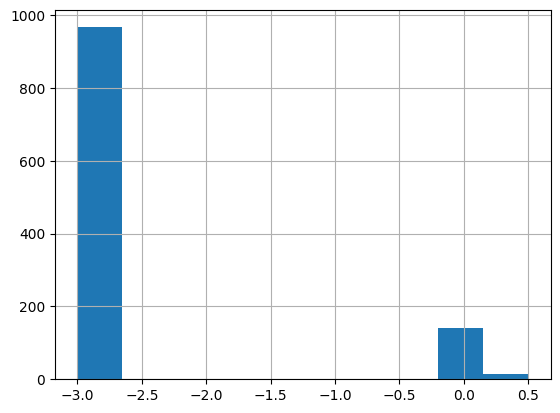

In [170]:
hexes_gdf['begin_2021_rel'].hist()

<AxesSubplot: >

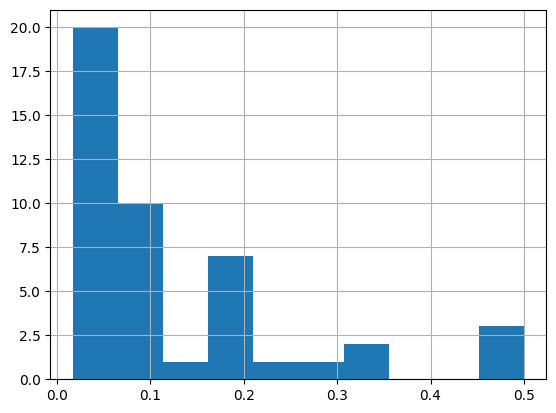

In [171]:
hexes_gdf.loc[hexes_gdf['begin_2021_rel'] > 0, 'begin_2021_rel'].hist()

In [172]:
hexes_gdf['end_2021_rel'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.count_2021 == 0) &
    (hexes_gdf.end_2021 == 0),
    'end_2021_rel'
] = -3

hexes_gdf.loc[
    (hexes_gdf.count_2021 > 0),
    'end_2021_rel'
] = hexes_gdf['end_2021'] / hexes_gdf['count_2021']

<AxesSubplot: >

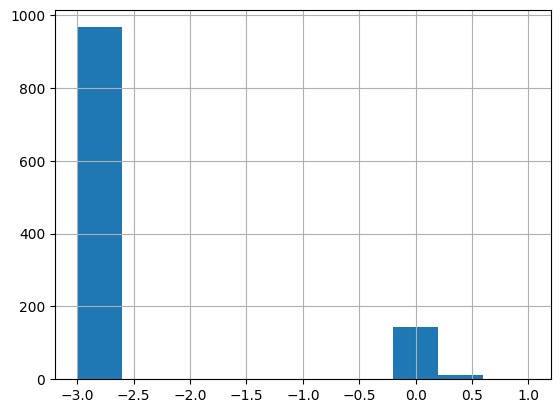

In [173]:
hexes_gdf['end_2021_rel'].hist()

<AxesSubplot: >

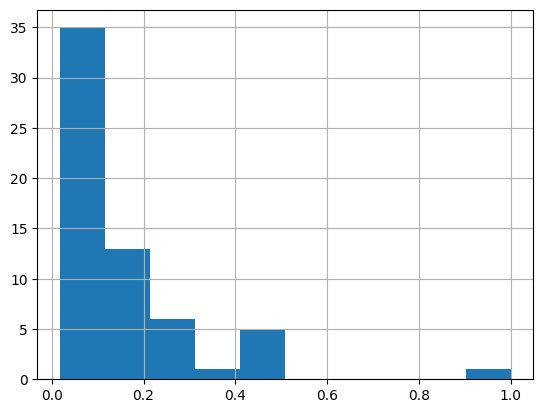

In [174]:
hexes_gdf.loc[hexes_gdf['end_2021_rel'] > 0, 'end_2021_rel'].hist()

In [175]:
hexes_gdf['count_2021_2020_rel'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.count_2020 == 0) &
    (hexes_gdf.count_2021 == 0),
    'count_2021_2020_rel'
] = -3

hexes_gdf.loc[
    (hexes_gdf.count_2020 == 0) &
    (hexes_gdf.count_2021 > 0),
    'count_2021_2020_rel'
] = -2

hexes_gdf.loc[
    (hexes_gdf.count_2020 > 0) &
    (hexes_gdf.count_2021 == 0),
    'count_2021_2020_rel'
] = -1

hexes_gdf.loc[
    (hexes_gdf.count_2020 > 0) &
    (hexes_gdf.count_2021 > 0),
    'count_2021_2020_rel'
] = hexes_gdf['count_2021'] / hexes_gdf['count_2020']

<AxesSubplot: >

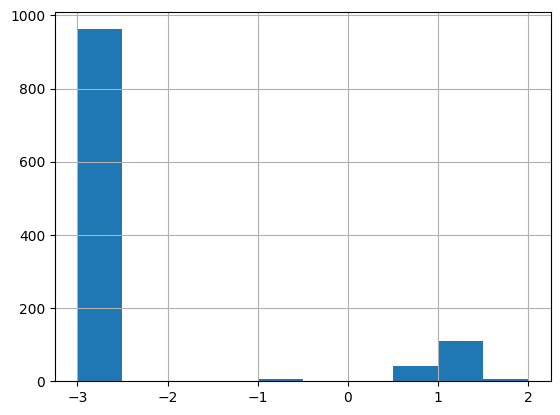

In [176]:
hexes_gdf['count_2021_2020_rel'].hist()

<AxesSubplot: >

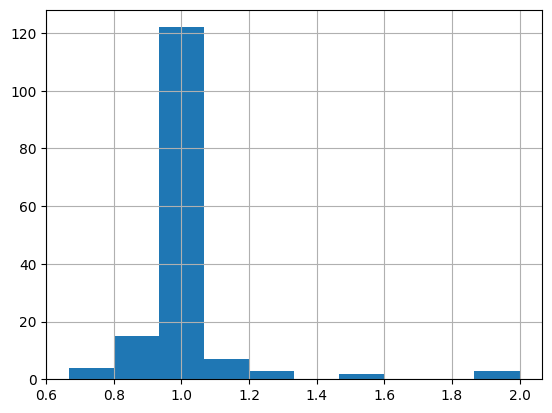

In [177]:
hexes_gdf.loc[hexes_gdf['count_2021_2020_rel'] > 0, 'count_2021_2020_rel'].hist()

In [178]:
hexes_gdf['net_profit_loss_to_revenue_2020'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.revenue == 0),
    'net_profit_loss_to_revenue_2020'
] = -3

hexes_gdf.loc[
    (hexes_gdf.revenue > 0),
    'net_profit_loss_to_revenue_2020'
] = hexes_gdf['net_profit_loss'] / hexes_gdf['revenue']

<AxesSubplot: >

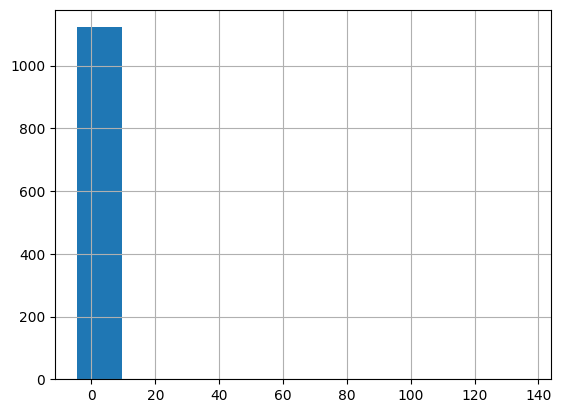

In [179]:
hexes_gdf['net_profit_loss_to_revenue_2020'].hist()

<AxesSubplot: >

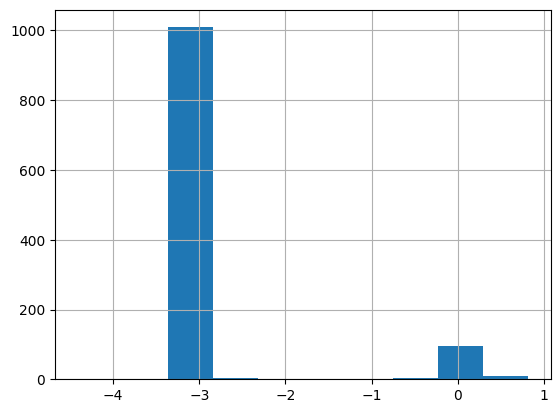

In [180]:
hexes_gdf.loc[
    (hexes_gdf['net_profit_loss_to_revenue_2020'] > -50) &
    (hexes_gdf['net_profit_loss_to_revenue_2020'] < 50),
    'net_profit_loss_to_revenue_2020'
].hist()

In [181]:
hexes_gdf['net_profit_loss_to_assets_2020'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.assets_balance == 0),
    'net_profit_loss_to_assets_2020'
] = -3

hexes_gdf.loc[
    (hexes_gdf.assets_balance > 0),
    'net_profit_loss_to_assets_2020'
] = hexes_gdf['net_profit_loss'] / hexes_gdf['assets_balance']

<AxesSubplot: >

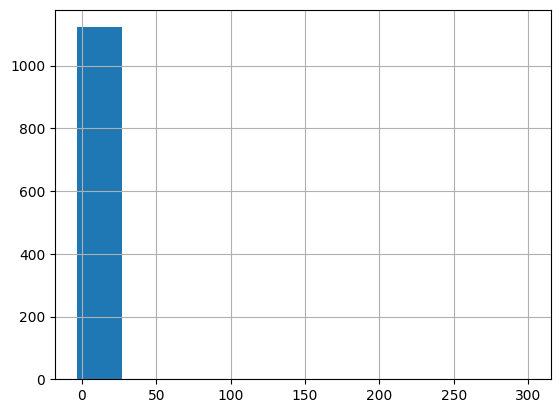

In [182]:
hexes_gdf['net_profit_loss_to_assets_2020'].hist()

<AxesSubplot: >

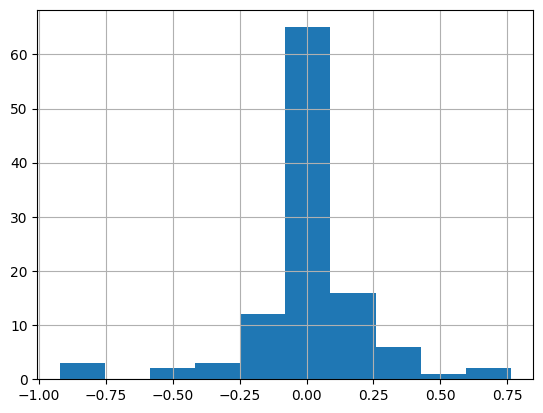

In [183]:
hexes_gdf.loc[
    (hexes_gdf['net_profit_loss_to_assets_2020'] > -1) &
    (hexes_gdf['net_profit_loss_to_assets_2020'] < 1),
    'net_profit_loss_to_assets_2020'
].hist()

In [184]:
hexes_gdf['short_borrowed_funds_to_revenue_2020'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.revenue == 0),
    'short_borrowed_funds_to_revenue_2020'
] = -3

hexes_gdf.loc[
    (hexes_gdf.revenue > 0),
    'short_borrowed_funds_to_revenue_2020'
] = hexes_gdf['short_borrowed_funds'] / hexes_gdf['revenue']

<AxesSubplot: >

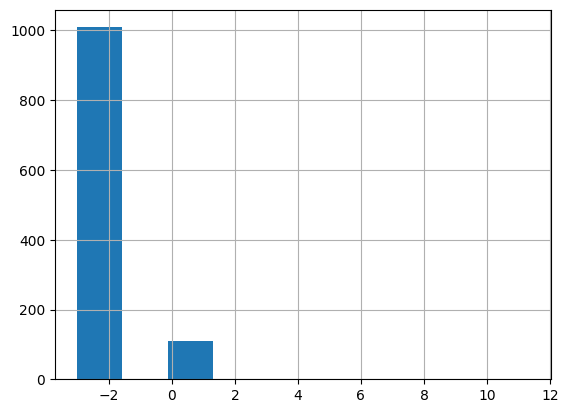

In [185]:
hexes_gdf['short_borrowed_funds_to_revenue_2020'].hist()

<AxesSubplot: >

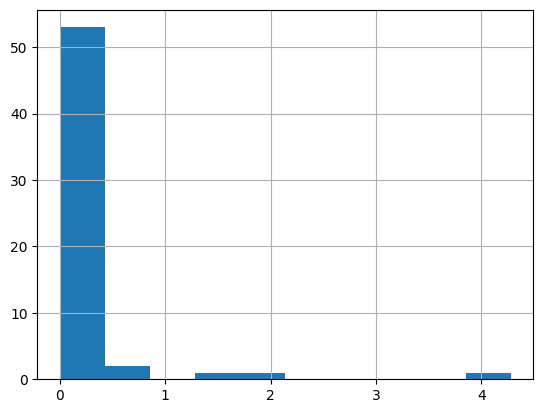

In [186]:
hexes_gdf.loc[
    (hexes_gdf['short_borrowed_funds_to_revenue_2020'] > 0) &
    (hexes_gdf['short_borrowed_funds_to_revenue_2020'] < 5),
    'short_borrowed_funds_to_revenue_2020'
].hist()

In [187]:
hexes_gdf['long_borrowed_funds_to_revenue_2020'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.revenue == 0),
    'long_borrowed_funds_to_revenue_2020'
] = -3

hexes_gdf.loc[
    (hexes_gdf.revenue > 0),
    'long_borrowed_funds_to_revenue_2020'
] = hexes_gdf['long_borrowed_funds'] / hexes_gdf['revenue']

<AxesSubplot: >

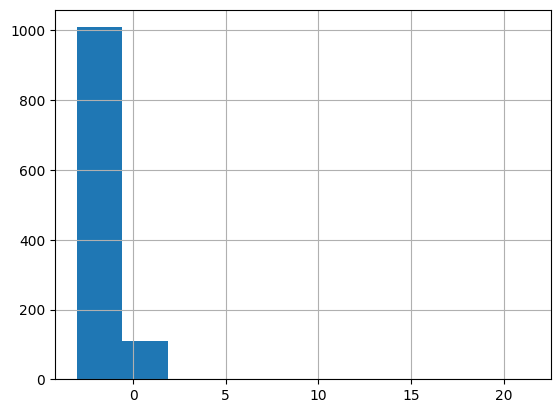

In [188]:
hexes_gdf['long_borrowed_funds_to_revenue_2020'].hist()

<AxesSubplot: >

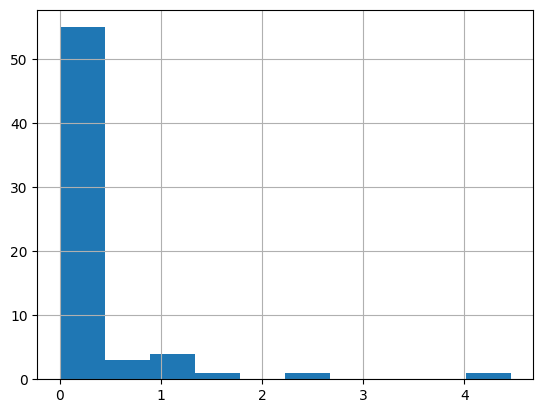

In [189]:
hexes_gdf.loc[
    (hexes_gdf['long_borrowed_funds_to_revenue_2020'] > 0) &
    (hexes_gdf['long_borrowed_funds_to_revenue_2020'] < 5),
    'long_borrowed_funds_to_revenue_2020'
].hist()

In [190]:
hexes_gdf['revenue_to_assets_2020'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.assets_balance == 0),
    'revenue_to_assets_2020'
] = -3

hexes_gdf.loc[
    (hexes_gdf.assets_balance > 0),
    'revenue_to_assets_2020'
] = hexes_gdf['revenue'] / hexes_gdf['assets_balance']

<AxesSubplot: >

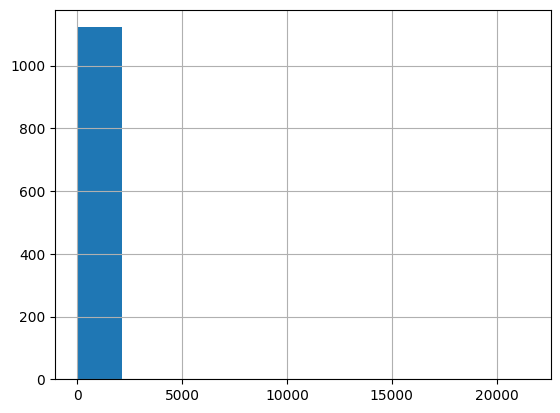

In [191]:
hexes_gdf['revenue_to_assets_2020'].hist()

<AxesSubplot: >

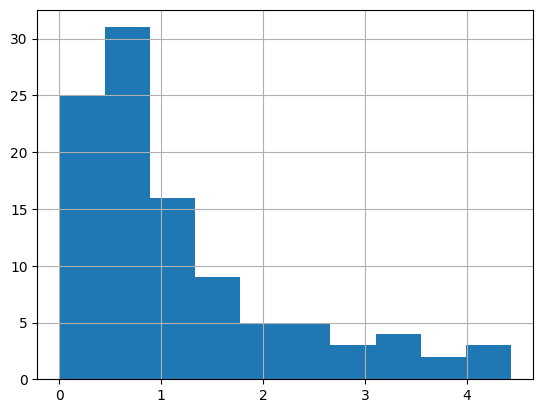

In [192]:
hexes_gdf.loc[
    (hexes_gdf['revenue_to_assets_2020'] > 0) &
    (hexes_gdf['revenue_to_assets_2020'] < 5),
    'revenue_to_assets_2020'
].hist()

In [193]:
hexes_gdf['assets_to_count_2020'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.count_2020 == 0),
    'assets_to_count_2020'
] = -3

hexes_gdf.loc[
    (hexes_gdf.count_2020 > 0),
    'assets_to_count_2020'
] = hexes_gdf['assets_balance'] / hexes_gdf['count_2020']

<AxesSubplot: >

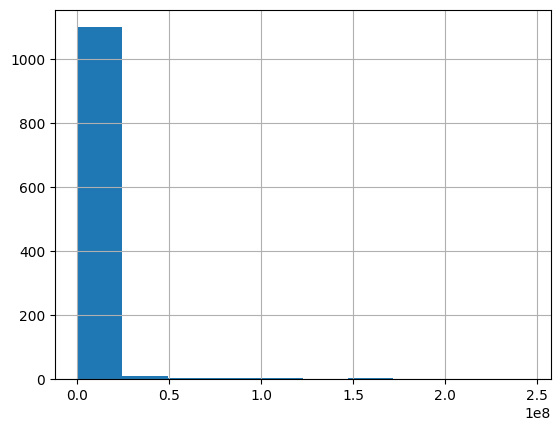

In [194]:
hexes_gdf['assets_to_count_2020'].hist()

<AxesSubplot: >

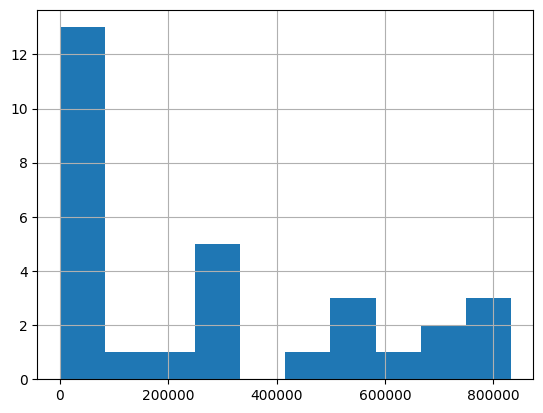

In [195]:
hexes_gdf.loc[
    (hexes_gdf['assets_to_count_2020'] > 0) &
    (hexes_gdf['assets_to_count_2020'] < 1e6),
    'assets_to_count_2020'
].hist()

In [196]:
hexes_gdf['net_profit_loss_to_count_2020'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.count_2020 == 0),
    'net_profit_loss_to_count_2020'
] = -3

hexes_gdf.loc[
    (hexes_gdf.count_2020 > 0),
    'net_profit_loss_to_count_2020'
] = hexes_gdf['net_profit_loss'] / hexes_gdf['count_2020']

<AxesSubplot: >

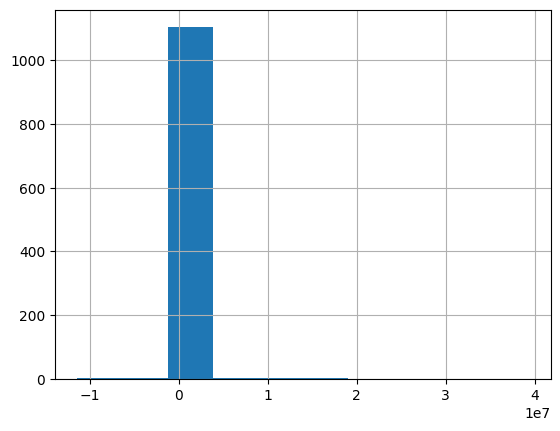

In [197]:
hexes_gdf['net_profit_loss_to_count_2020'].hist()

<AxesSubplot: >

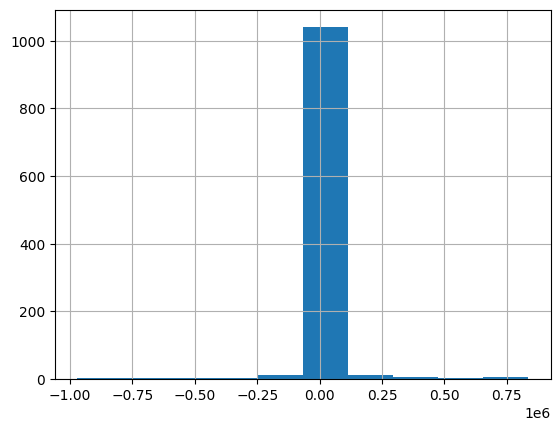

In [198]:
hexes_gdf.loc[
    (hexes_gdf['net_profit_loss_to_count_2020'] > -1e6) &
    (hexes_gdf['net_profit_loss_to_count_2020'] < 1e6),
    'net_profit_loss_to_count_2020'
].hist()

In [199]:
hexes_gdf['revenue_to_count_2020'] = np.nan

hexes_gdf.loc[
    (hexes_gdf.count_2020 == 0),
    'revenue_to_count_2020'
] = -3

hexes_gdf.loc[
    (hexes_gdf.count_2020 > 0),
    'revenue_to_count_2020'
] = hexes_gdf['revenue'] / hexes_gdf['count_2020']

<AxesSubplot: >

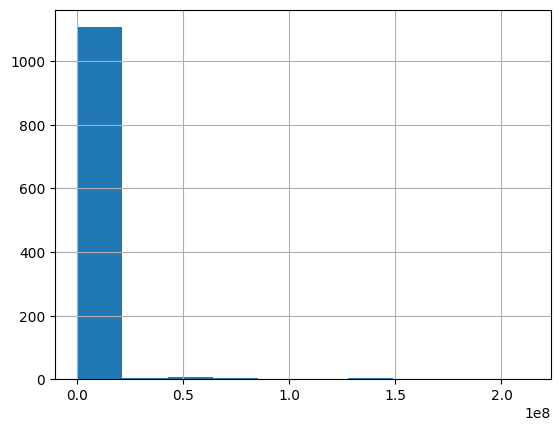

In [200]:
hexes_gdf['revenue_to_count_2020'].hist()

<AxesSubplot: >

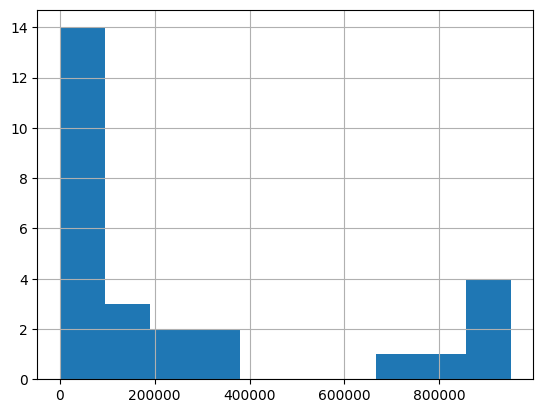

In [201]:
hexes_gdf.loc[
    (hexes_gdf['revenue_to_count_2020'] > 0) &
    (hexes_gdf['revenue_to_count_2020'] < 1e6),
    'revenue_to_count_2020'
].hist()

In [202]:
hexes_gdf.head(10)

,geometry,hex_id,h3_id_5,assets_balance,short_borrowed_funds,long_borrowed_funds,revenue,net_profit_loss,count_2020,count_2021,begin_2021,end_2021,begin_2021_rel,end_2021_rel,count_2021_2020_rel,net_profit_loss_to_revenue_2020,net_profit_loss_to_assets_2020,short_borrowed_funds_to_revenue_2020,long_borrowed_funds_to_revenue_2020,revenue_to_assets_2020,assets_to_count_2020,net_profit_loss_to_count_2020,revenue_to_count_2020
0,"POLYGON ((78.11260 58.82547, 78.22430 58.89766...",850b128bfffffff,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000e+00,-3.000000e+00,-3.000000e+00
1,"POLYGON ((87.88468 57.67118, 87.83945 57.76124...",850b8333fffffff,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000e+00,-3.000000e+00,-3.000000e+00
2,"POLYGON ((79.61531 57.06915, 79.78766 57.05310...",850ba013fffffff,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000e+00,-3.000000e+00,-3.000000e+00
3,"POLYGON ((80.99313 58.32557, 81.05507 58.23779...",850ba163fffffff,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000e+00,-3.000000e+00,-3.000000e+00
4,"POLYGON ((81.37080 59.42336, 81.18940 59.44168...",850bac73fffffff,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000e+00,-3.000000e+00,-3.000000e+00
5,"POLYGON ((84.82035 56.80321, 84.76899 56.89299...",850b846ffffffff,850b846ffffffff,738688370.0,318065282.0,173000.0,902822614.0,67381945.0,42.0,39.0,2.0,1.0,0.051282,0.025641,0.928571,0.074635,0.091218,0.352301,0.000192,1.222197,1.758782e+07,1.604332e+06,2.149578e+07
6,"POLYGON ((79.74748 59.33592, 79.68075 59.42250...",850bac93fffffff,850bac93fffffff,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.000000,0.000000,1.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,0.000000e+00,0.000000e+00,0.000000e+00
7,"POLYGON ((84.80852 58.69731, 84.98301 58.67418...",850baa47fffffff,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000e+00,-3.000000e+00,-3.000000e+00
8,"POLYGON ((81.83341 60.42278, 82.01891 60.40352...",850bad63fffffff,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000e+00,-3.000000e+00,-3.000000e+00
9,"POLYGON ((81.46161 60.46053, 81.58355 60.52840...",850bad0ffffffff,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000e+00,-3.000000e+00,-3.000000e+00


In [203]:
hexes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>

Int64Index: 1123 entries, 0 to 1122

Data columns (total 23 columns):

 #   Column                                Non-Null Count  Dtype   

---  ------                                --------------  -----   

 0   geometry                              1123 non-null   geometry

 1   hex_id                                1123 non-null   object  

 2   h3_id_5                               1123 non-null   object  

 3   assets_balance                        1123 non-null   float64 

 4   short_borrowed_funds                  1123 non-null   float64 

 5   long_borrowed_funds                   1123 non-null   float64 

 6   revenue                               1123 non-null   float64 

 7   net_profit_loss                       1123 non-null   float64 

 8   count_2020                            1123 non-null   float64 

 9   count_2021                            1123 non-null   float64 

 10  begin_2021                            1123 non-nu

In [209]:
hexes_gdf.to_csv(
    f'home/jovyan/work/hexes_{reg}_ul_2.csv.gz',
    sep=';',
    compression='gzip'
)

In [210]:
storage.personal.save(f'hexes_{reg}_ul_2.csv.gz')

2022-11-17 21:28.06 [info     ] check for directory            fs=localfs path=hexes_70_ul_2.csv.gz

2022-11-17 21:28.06 [info     ] save file                      path=hexes_70_ul_2.csv.gz

2022-11-17 21:28.06 [info     ] open file for read             fs=localfs path=hexes_70_ul_2.csv.gz

2022-11-17 21:28.06 [info     ] open file for write            fs=s3fs path=hexes_70_ul_2.csv.gz


In [206]:
hexes_gdf.drop(columns=['h3_id_5']).to_parquet(
    f'home/jovyan/work/hexes_{reg}_ul_2.parquet.gzip',
    compression='gzip',
    index=False,
    engine='pyarrow' 
)

In [207]:
storage.personal.save(f'hexes_{reg}_ul_2.parquet.gzip')

2022-11-17 21:26.06 [info     ] check for directory            fs=localfs path=hexes_70_ul_2.parquet.gzip

2022-11-17 21:26.06 [info     ] save file                      path=hexes_70_ul_2.parquet.gzip

2022-11-17 21:26.06 [info     ] open file for read             fs=localfs path=hexes_70_ul_2.parquet.gzip

2022-11-17 21:26.06 [info     ] open file for write            fs=s3fs path=hexes_70_ul_2.parquet.gzip


In [208]:
storage.personal.save('Geo_EGRUL_3_1.ipynb')

2022-11-17 21:26.23 [info     ] check for directory            fs=localfs path=Geo_EGRUL_3_1.ipynb

2022-11-17 21:26.23 [info     ] save file                      path=Geo_EGRUL_3_1.ipynb

2022-11-17 21:26.23 [info     ] open file for read             fs=localfs path=Geo_EGRUL_3_1.ipynb


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/work/Geo_EGRUL_3_1.ipynb'